In [15]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import re
from sklearn.feature_extraction.text import CountVectorizer
import torchvision.transforms as transforms
import matplotlib.pyplot as plt

import torch
from torch.utils.data import DataLoader
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms

from sklearn.metrics import f1_score

In [2]:
def CleanText(text):
    text = re.sub(r'''[\[|\]]''', "", text).split()
    text = np.array(text, dtype="float64")
    return text

In [3]:
df = pd.read_csv("all_data_with_identitiesEmbedded.csv")

df = df.loc[:, ["comment_text", "split", "na_gender", "na_race", "toxicity", "male", "female", "transgender", "black", "white", "asian", "latino"]]

df['toxicity'] = df['toxicity'].apply(lambda score: np.round(score))
df['comment_text'] = df['comment_text'].apply(lambda text: CleanText(text))

df['male'] = df['male'].apply(lambda x: round(x))
df['female'] = df['female'].apply(lambda x: round(x))
df['transgender'] = df['transgender'].apply(lambda x: round(x))
df['black'] = df['black'].apply(lambda x: round(x))
df['white'] = df['white'].apply(lambda x: round(x))
df['asian'] = df['asian'].apply(lambda x: round(x))
df['latino'] = df['latino'].apply(lambda x: round(x))

In [170]:
# Updating values for training_data
training_data = df[df['split'] == 'train']
#training_data = training_data[(training_data['na_gender'] == 0) | (training_data['na_race'] == 0)]
#training_data = training_data.drop(training_data.query('toxicity==0').sample(frac=.85).index)

# Getting test_data
test_data = df[df['split'] == 'test']
#test_data = test_data[(test_data['na_gender'] == 0) | (test_data['na_race'] == 0)]

# Getting validation_data
validation_data = df[df['split'] == 'val']
#validation_data = validation_data[(validation_data['na_gender'] == 0) | (validation_data['na_race'] == 0)]
#validation_data = validation_data.drop(validation_data.query('toxicity==0').sample(frac=.85).index)

In [183]:
### Set parameters for the model
torch.manual_seed(42) # set fixed random seed for reproducibility
batch_size = 128
epochs = 1000
lr = 0.00002

cuda = True # Set this if training on GPU
cuda = cuda and torch.cuda.is_available()
device = torch.device("cuda" if cuda else "cpu")
print("Using "+repr(device))

Using device(type='cuda')


In [184]:
transform = transforms.Compose([transforms.ToTensor()])

# Creating data loaders
X_train = np.array(training_data['comment_text'].values.tolist())
Y_train = np.array(training_data['toxicity'].values.tolist())

X_test = np.array(test_data['comment_text'].values.tolist())
Y_test = np.array(test_data['toxicity'].values.tolist())

X_val = np.array(validation_data['comment_text'].values.tolist())
Y_val = np.array(validation_data['toxicity'].values.tolist())

                    
prepare_trainloader = []
for i in range(len(X_train)):
    prepare_trainloader.append([X_train[i], Y_train[i]])
    
prepare_testloader = []
for i in range(len(X_test)):
    prepare_testloader.append([X_test[i], Y_test[i]])
    
prepare_validloader = []
for i in range(len(X_val)):
    prepare_validloader.append([X_val[i], Y_val[i]])

train_loader = torch.utils.data.DataLoader(prepare_trainloader, batch_size=batch_size, shuffle=True)
valid_loader = torch.utils.data.DataLoader(prepare_validloader, batch_size=batch_size, shuffle=True)
test_loader = torch.utils.data.DataLoader(prepare_testloader, batch_size=batch_size, shuffle=True)

In [185]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #self.fc1 = nn.Sequential(nn.Linear(768, 128), nn.ReLU(), nn.Dropout(p=0.2), nn.MaxPool1d(kernel_size=2))
        self.fc1 = nn.Sequential(nn.Linear(768, 64), nn.ReLU(), nn.Dropout(p=0.2))
        self.fc2 = nn.Sequential(nn.Linear(64, 32), nn.ReLU())
        self.fc3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()
        #self.logsoftmax = nn.LogSoftmax(dim=1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.fc2(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

In [186]:
# Setting up model parameters
model = Net().to(device)
optimizer = optim.AdamW(model.parameters(), lr=lr)
loss_function = nn.BCELoss()
#loss_function = nn.MSELoss()
#loss_function = nn.NLLLoss()



# Initialising early stopping criterias
early_stopping = 10
notImproved = 0
bestLoss = None
bestModel = None

trainArr = []
valArr = []

bestf1 = 0

for epoch in range(1, epochs + 1):
    
    train_loss = 0.0
    for batch_idx, data in enumerate(train_loader):
        
        # get the input
        inputs, labels = data
        
        inputs = inputs.unsqueeze(1)
        
        inputs = inputs.to(device).float()
        labels = labels.to(device).float()
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize            
        outputs = model(inputs).squeeze()
        
        
        loss = loss_function(outputs, labels)
        
        loss.backward()
        
        optimizer.step()
        
        train_loss += loss.item()
    
    train_loss /= len(train_loader.dataset)
    
    print('====> Epoch: {} Average training loss: {:.6f}'.format(epoch, train_loss))
    
    trainArr.append(train_loss)
    
    valid_loss = 0
    labs = []
    preds = []
    
    model.eval()
    with torch.no_grad():        
        for batch_idx, data in enumerate(valid_loader):
            # get the input
            inputs, labels = data
            inputs = inputs.unsqueeze(1)
            inputs = inputs.to(device).float()
            #labels = labels.to(device).long()
            labels = labels.to(device).float()
            
            outputs = model(inputs).squeeze()
            
            labs.extend(labels)
            preds.extend(torch.round(outputs))
            #preds.extend(outputs.argmax(axis=1))
            
            valid_loss += loss_function(outputs, labels).item()
    
    valid_loss /= len(valid_loader.dataset)
    
    valArr.append(valid_loss)
    
    print('====> Validation set loss: {:.6f}'.format(valid_loss))
    
    print("Accuracy on Validation set: ", CheckAccuracy(labs, preds))
    
    f1 = f1_score(torch.Tensor(labs).numpy(), torch.Tensor(preds).numpy(), zero_division=1)
    
    print("F1_score: ", f1)
    
    #if f1 > bestf1:
    #    bestModel = model
    
    print("\n")
    
    # Initialising params for early stopping
    if bestLoss == None:
        bestLoss = valid_loss
        
    # Checks for early stopping
    if valid_loss <= bestLoss:
        notImproved = 0
        bestLoss = valid_loss
        bestModel = model
    else:
        notImproved +=1
        
    # Converges if the training has not improved for a certain amount of iterations
    if notImproved >= early_stopping:
        break

model = bestModel

torch.save(model, 'bestModelFullyConnectedNetwork.pth')

====> Epoch: 1 Average training loss: 0.002758
====> Validation set loss: 0.002033
Accuracy on Validation set:  0.9213590084108012
F1_score:  0.0


====> Epoch: 2 Average training loss: 0.001949
====> Validation set loss: 0.001812
Accuracy on Validation set:  0.9220451527224436
F1_score:  0.01784718349135527


====> Epoch: 3 Average training loss: 0.001817
====> Validation set loss: 0.001756
Accuracy on Validation set:  0.9246347941567065
F1_score:  0.1271468854139964


====> Epoch: 4 Average training loss: 0.001787
====> Validation set loss: 0.001739
Accuracy on Validation set:  0.9252766710934042
F1_score:  0.17010816125860373


====> Epoch: 5 Average training loss: 0.001773
====> Validation set loss: 0.001729
Accuracy on Validation set:  0.9255422753430722
F1_score:  0.1854721549636804


====> Epoch: 6 Average training loss: 0.001763
====> Validation set loss: 0.001721
Accuracy on Validation set:  0.9259628154050464
F1_score:  0.20109863864342015


====> Epoch: 7 Average training lo

====> Validation set loss: 0.001634
Accuracy on Validation set:  0.9295484727755644
F1_score:  0.3111880545336508


====> Epoch: 52 Average training loss: 0.001605
====> Validation set loss: 0.001633
Accuracy on Validation set:  0.9299026117751218
F1_score:  0.30072863766835944


====> Epoch: 53 Average training loss: 0.001602
====> Validation set loss: 0.001632
Accuracy on Validation set:  0.9299247454625941
F1_score:  0.3011037527593819


====> Epoch: 54 Average training loss: 0.001600
====> Validation set loss: 0.001636
Accuracy on Validation set:  0.9293714032757857
F1_score:  0.32919907504729873


====> Epoch: 55 Average training loss: 0.001597
====> Validation set loss: 0.001636
Accuracy on Validation set:  0.9295484727755644
F1_score:  0.3314429741650914


====> Epoch: 56 Average training loss: 0.001595
====> Validation set loss: 0.001632
Accuracy on Validation set:  0.9295706064630368
F1_score:  0.3112554112554113


====> Epoch: 57 Average training loss: 0.001592
====> Validati

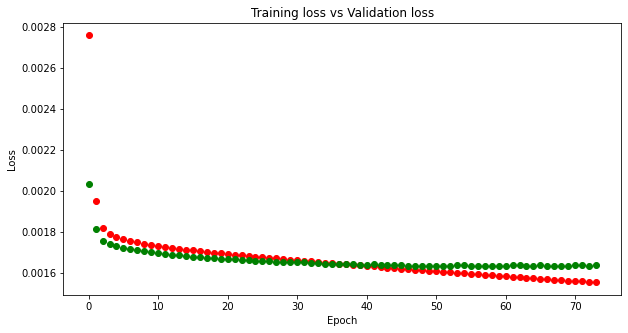

In [187]:
plt.figure(figsize=(10,5))
plt.scatter(np.arange(0,len(trainArr)), trainArr, color='r')
plt.scatter(np.arange(0,len(valArr)), valArr, color='g')
plt.title("Training loss vs Validation loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
#plt.legend(loc="upper left")
plt.show()

In [188]:
labs = []
preds = []

model.eval()
with torch.no_grad():        
    for batch_idx, data in enumerate(test_loader):
        # get the input
        inputs, labels = data
        inputs = inputs.unsqueeze(1)
        inputs = inputs.to(device).float()
        labels = labels.to(device).float()
        
        outputs = model(inputs).squeeze()
        
        labs.extend(labels)
        preds.extend(torch.round(outputs))
        
print("Accuracy on test set: ", CheckAccuracy(labs, preds))

f1 = f1_score(torch.Tensor(labs).numpy(), torch.Tensor(preds).numpy(), zero_division=1)
print("F1_score: ", f1)


true_positives = 0
true_negatives = 0
false_positives = 0
false_negatives = 0

for i in range(len(labs)):
    if labs[i]==1 and preds[i]==1:
        true_positives += 1
    if labs[i]==0 and preds[i]==0:
        true_negatives += 1
    if labs[i]==0 and preds[i]==1:
        false_positives += 1
    if labs[i]==1 and preds[i]==0:
        false_negatives += 1
        


print("true_positives", true_positives)
print("true_negatives", true_negatives)
print("false_positives", false_positives)
print("false_negatives", false_negatives)

Accuracy on test set:  0.926365280830007
F1_score:  0.3051421316216407
true_positives 2163
true_negatives 121768
false_positives 1174
false_negatives 8677


In [ ]:
from diffprivlib.models import PCA

clf = PCA(epsilon=0.1)

gg = clf.fit_transform(X_train[:1000])